#### For Colab

In [1]:
"""
function ClickConnect(){
    console.log("Working");
    document.querySelector("colab-toolbar-button").click() 
}
var i = setInterval(ClickConnect, 900000)
clearInterval(i)
"""

'\nfunction ClickConnect(){\n    console.log("Working");\n    document.querySelector("colab-toolbar-button").click() \n}\nvar i = setInterval(ClickConnect, 900000)\nclearInterval(i)\n'

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
drive_dir = '/content/drive/My Drive/MAGMA: Summarization/'

#### Install Libraries

In [4]:
!pip install transformers==4.1.1
!pip install -U sentencepiece!=0.1.92
!pip install -U datasets
!pip install rouge_score

     |████████████████████████████████| 1.5MB 5.4MB/s 
     |████████████████████████████████| 890kB 18.4MB/s 
     |████████████████████████████████| 2.9MB 13.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=0ccb52a74adfbda3801a8f82bad1b8c440c74961ffafcbbb7a8d0cf6314c6c1f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.2MB 5.7MB/s 
     |████████████████████████████████| 163kB 4.1MB/s 
     |████████████████████████████████| 17.7MB 197kB/s 
     |████████████████████████████████| 245kB 52.7MB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


### **Config**

In [5]:
import os
import sys

sys.path.insert(0, drive_dir)
import config

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [6]:
MODEL = 'bart'
MODELS = {}

# Output path
if 'bart' in MODEL:
    data_dir = '/content/drive/My Drive/MAGMA: Summarization/datasets/karger_books_chunk_chapter/bart/'

    OUTPUT_PATH = drive_dir+'summarization/baseline_output/bart/'
    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)
elif 'pegasus' in MODEL:
    data_dir = '/content/drive/My Drive/MAGMA: Summarization/datasets/karger_books_chunk_chapter/pegasus/'

    OUTPUT_PATH = drive_dir+'summarization/baseline_output/pegasus/'
    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)

### **Init**

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
from tqdm import tqdm
from textwrap import fill

### **Function Definition**

##### Import Model and Tok

In [8]:
def import_model_tok(model_name_or_path):
    global MODELS

    if model_name_or_path in MODELS.keys():
        print('[+] model already present in cache\n')
        return MODELS[model_name_or_path]
    print('[*] importing the model\n')

    if 'bart' in MODEL:
        from transformers import BartForConditionalGeneration, BartTokenizer

        model = BartForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = BartTokenizer.from_pretrained(model_name_or_path)
    elif 'pegasus' in MODEL:
        from transformers import PegasusForConditionalGeneration, PegasusTokenizer

        model = PegasusForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = PegasusTokenizer.from_pretrained(model_name_or_path)

    MODELS[model_name_or_path] = model, tokenizer
    print('[+] the model is now present in cache\n')
    return MODELS[model_name_or_path]

##### Nice Print

In [9]:
def print_example(idx, text, summ, bull):
    print(idx)
    print(fill(text, 150))
    print()
    print('Prediction:')
    print(fill(summ, 100))
    print()
    print('Reference:')
    print(fill(bull, 100))
    print()
    print(''.join(['#']*100))
    print()

##### Print Examples

In [10]:
def print_examples(model_name_or_path, df, n_examples=10):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)
    df_examples = df.sample(n_examples, axis='index', random_state=config.SEED)
    
    for idx, row in df_examples.iterrows():

        summ_enc = model.generate(
            tokenizer.encode(row.text, return_tensors='pt').to(device),
            min_length = config.BULLETS_MIN_LEN,
            max_length = config.BULLETS_MAX_LEN,
            length_penalty = config.LENGTH_PENALTY,
            num_beams = config.NUM_BEAMS,
            no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
            early_stopping = True)[0]
        summ = tokenizer.decode(summ_enc, skip_special_tokens=True)

        print_example(idx, row.text, summ, row.bullets)

##### Plot Evaluation

In [11]:
def plot_evaluation(model_name_or_path):
    df = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv').set_index(['book', 'chapter'])

    prf = ['precision', 'recall', 'fmeasure']
    num_rouge = len(config.ROUGE_TYPES)

    from matplotlib.cm import get_cmap
    color = get_cmap('tab10')(range(num_rouge))
    def set_box_color(b, c):
        for k in b.keys():
            plt.setp(b[k], color=c)
    
    xticks = 2*np.array(np.arange(1, num_rouge+1))

    fig, ax = plt.subplots(figsize=(10, 6))
    box_plt_list = [plt.boxplot(
        [df[rouge+'_'+r+'_'+model_name_or_path].tolist() for r in prf],
        positions= xticks+var,
        sym='+',
        widths=0.4,
        patch_artist=False,
        meanline=True,
        showmeans=True)\
        for rouge, var in zip(config.ROUGE_TYPES,
            np.linspace(-0.15*num_rouge, 0.15*num_rouge, num_rouge))]

    for i, bp in enumerate(box_plt_list):
        set_box_color(bp, color[i])
        plt.plot([], c=color[i], label=prf[i])
    plt.legend()

    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title('Evaluation Results', fontsize='xx-large')
    ax.set_ylabel('Rouge', fontsize='x-large')
    plt.xticks(xticks, config.ROUGE_TYPES, fontsize='x-large')
    plt.show()

## **Baseline**

In [12]:
df_train = pd.read_csv(data_dir + 'train.csv').set_index(['book', 'chapter'])
df_val = pd.read_csv(data_dir + 'val.csv').set_index(['book', 'chapter'])
df_test = pd.read_csv(data_dir + 'test.csv').set_index(['book', 'chapter'])

### **Print and Summarization**

##### Print Train Examples

In [23]:
print_examples('facebook/bart-base', df_train)

[+] model already present in cache

(9781910797273, 'chp5')
In most patients, these can be prevented or alleviated with paracetamol (acetaminophen)/non-steroidal anti-inflammatory drugs (NSAIDs) on the day of
injection . For weekly intramuscular therapy, patients may choose to inject on a day when they have few work or social engagements (commonly at the
weekend) . It is important to inform patients of the potential side effects so that they can plan for when they need to rest or take prophylactic pain
relief . Rarer side effects of IFNbeta therapy include mood disorders, alopecia and bone marrow/hepatic dysfunction (which requires regular blood
monitoring, as discussed below) . Before starting interferon therapies, the following blood tests are important . full or complete blood count (FBC or
CBC) . liver function tests (LFT) . urea and electrolytes . protein electrophoresis . The FBC and LFT should be repeated at 1 month, then every 3
months for the first year and every 6 months ther

##### Print Val Examples

In [24]:
print_examples('facebook/bart-base', df_val)

[+] model already present in cache

(9781910797723, 'chp3')
It is also important in regulating T helper cell function . In cancer, IL-6 is also important in . differentiation of myeloid-derived suppressor cells
(MDSCs) . regulation of self-renewal of cancer stem cells . inhibition of apoptosis, thereby promoting tumor growth and progression . enhancing
angiogenesis . the development of cancer cachexia syndrome . IL-6 signaling occurs through binding to the IL-6 receptor in conjunction with gp130
protein and activation of the JAK/STAT signaling pathway (janus kinase/signal transducer and activator of transcription) . Antibodies to IL-6 have
been successfully used in inflammatory conditions such as rheumatoid arthritis (RA), and tocilizumab is registered with the FDA for the treatment of
adult and juvenile forms of RA . Therapeutic antibodies to IL-6 have also been trialed in cancer patients, including studies in the management of
cancer cachexia syndrome . Other cancer therapies target 

##### Summarize Test and Print Examples

In [17]:
def summarize(model_name_or_path, df, batch_size):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)

    input_ids = tokenizer(df.text.tolist(), return_tensors='pt', padding=True).input_ids
    input_ids = input_ids.split(batch_size)

    summs = []

    pbar = tqdm(total=len(input_ids), 
                position=0,
                leave=True,
                file=sys.stdout)
    for batch in input_ids:

        summ_enc = model.generate(
            batch.to(device),
            min_length = config.BULLETS_MIN_LEN,
            max_length = config.BULLETS_MAX_LEN,
            length_penalty = config.LENGTH_PENALTY,
            num_beams = config.NUM_BEAMS,
            no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
            early_stopping = True)
        summ = tokenizer.batch_decode(summ_enc, skip_special_tokens=True)
        summs += summ

        pbar.update(1)
    pbar.close()

    df['summary_'+model_name_or_path] = summs

    return df

In [18]:
df_test = summarize('facebook/bart-base', df_test, 10)

[+] model already present in cache

100%|██████████| 17/17 [04:21<00:00, 15.35s/it]


### **Evaluation**

In [19]:
from datasets import load_metric

metric = load_metric("rouge")

##### Evaluate summaries

In [20]:
def evaluate_model(df, model_name_or_path):
    rouge_res =\
        df[['bullets', 'summary_'+model_name_or_path]]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)

    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df[r+'_'+prf+'_'+model_name_or_path] =\
                rouge_res.map(lambda score: score[r][0][i])
    
    df_save = df[[c for c in df_test.columns if c.startswith('rouge')]]
    df_save.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv')
    
    return df

In [21]:
df_test = evaluate_model(df_test, 'facebook/bart-base')

##### Plot Evaluation

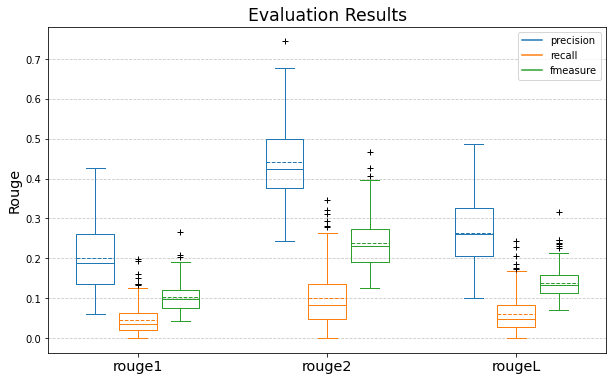

In [22]:
plot_evaluation('facebook/bart-base')